In [1]:
!ls ../input/openigraphdata/

200_Keywords  All_Keywords   Neg_Keywords
500_Keywords  Mesh_Keywords  New_Keywords


In [2]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 468.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.2/658.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.7/317.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.0/467.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=7932e002e8be9788da5575dcf2fa2bf04baa8b24c39b1651a6e3fd1f3740d506
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [3]:
import numpy as np
import pandas as pd
import re
import csv
import seaborn as sns
import os
from PIL import Image
import nltk
from nltk import bigrams
import itertools
import cv2
import collections
from pathlib import Path
from collections import Counter
from random import sample
import math
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import sentence_bleu
import pickle
import random
from operator import itemgetter
import spacy
from sklearn.metrics import f1_score
from torch_geometric.data import HeteroData
# from torch_geometric.transforms import RandomLinkSplit
# from torch_geometric.loader import LinkNeighborLoader

from random import sample
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
# import torchxrayvision as xrv
from itertools import combinations
from nltk import everygrams

from transformers import BertModel
from transformers import BertTokenizer
from torchvision import transforms, models
from skimage import data, io, filters
from torch.utils.data import DataLoader, Dataset
import torch.optim.lr_scheduler as lr_scheduler



from sklearn.datasets import make_multilabel_classification
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score

import os.path as osp
import argparse

import torch
from torch.nn import Linear
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv,GATConv, to_hetero, Linear
from torch_geometric.data import HeteroData
from sklearn.metrics import f1_score
import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear,GraphConv,HeteroLinear

import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def get_f1_score(preds,labels):
    
    pos_idx = preds >= 0.5
    neg_idx = preds < 0.5
    preds[pos_idx] = 1
    preds[neg_idx] = 0
    
    return f1_score(labels, preds)


def get_word_edge_index(word_edges,word2id):
    n = word_edges.shape[0]
    word_edge_index = np.empty((2,n),dtype=np.int32)
    rev_word_edge_index = np.empty((2,n),dtype=np.int32)
    
    for i,edge in enumerate(word_edges):
        word_edge_index[0,i] = word2id[edge[0]]
        word_edge_index[1,i] = word2id[edge[1]]
        
    rev_word_edge_index[0,:] = word_edge_index[1,:]
    rev_word_edge_index[1,:] = word_edge_index[0,:]  
        
    return word_edge_index,rev_word_edge_index


def get_image_edge_index(image_edges,img2id):
    n = image_edges.shape[0]
    image_edge_index = np.empty((2,n),dtype=np.int32)
    
    for i,edge in enumerate(image_edges):
        image_edge_index[0,i] = img2id[edge[0]]
        image_edge_index[1,i] = img2id[edge[1]]
        
    return image_edge_index


def get_img_keywords_dict(img_ids,df):
    img_keywords_dict = {}
    keywords = df['Keywords'].values
    for i,img in enumerate(img_ids):
        kw = keywords[i].split(',')
        img_keywords_dict[img] = kw
    return img_keywords_dict


def get_training_edges(img_ids,img_keywords_dict,word_vocab,img2id,word2id,neg_samp=10):
    training_edges = []
    training_labels = []
    for i,img in enumerate(img_ids):
        
        pos_kw = img_keywords_dict[img]
        
        neg_set = list(set(word_vocab).difference(set(pos_kw)))
        neg_kw = list(random.sample(neg_set,neg_samp))
        
        all_kw = pos_kw + neg_kw
        num_kw = len(all_kw)
        labels = [1]*len(pos_kw) + [0]*len(neg_kw)
        
        # create an array for edges
        edges = np.empty((2,num_kw),dtype=np.int32)
        
        # first column will be image id (repeat same value)
        edges[0,:] = np.full(num_kw,img2id[img],dtype=np.int32)
        edges[1,:] = [word2id[kw] for kw in all_kw]
        
    
        training_edges.append(edges)
        training_labels.append(labels)

    training_edges = np.concatenate(training_edges,axis=1)
    training_labels = np.concatenate(training_labels,axis=0)
    
    idx = np.random.permutation(training_labels.shape[0])
    training_edges = training_edges[:,idx]
    training_labels = training_labels[idx]
    return training_edges, training_labels



def get_val_test_edges(img_ids,img_keywords_dict,word_vocab,img2id,word2id):
    val_edges = []
    val_labels = []
    num_kw = len(word_vocab)
    word_vocab_id = [word2id[w] for w in word_vocab]
    
    for i,img in enumerate(img_ids):
        pos_kw = img_keywords_dict[img]
        
        # create an array for edges
        edges = np.empty((2,num_kw),dtype=np.int32)
        
        # first column will be image id (repeat same value)
        edges[0,:] = np.full(num_kw,img2id[img],dtype=np.int32)
        edges[1,:] = word_vocab_id
        
        labels = np.zeros(num_kw,dtype=np.float32)
        pos_idx = [word2id[w] for w in pos_kw]
        
        labels[pos_idx] = 1.0
        
    
        val_edges.append(edges)
        val_labels.append(labels)

    val_edges = np.concatenate(val_edges,axis=1)
    val_labels = np.concatenate(val_labels,axis=0)
    
    return val_edges, val_labels


def get_image_word_edges(img_ids,sample_img_ids,img_keywords_dict,img2id,word2id):
    
    img_word_edges = []
    for i,img in enumerate(img_ids):
        if img not in sample_img_ids:
            kw = img_keywords_dict[img]
            edges = np.empty((2,len(kw)),dtype=np.int32)
            edges[0,:] = np.full(len(kw),img2id[img],dtype=np.int32)
            edges[1,:] = [word2id[w] for w in kw] 
            img_word_edges.append(edges)
            
    img_word_edges = np.concatenate(img_word_edges,axis=1)
    
    rev_img_word_edges = np.empty(img_word_edges.shape,dtype=np.int32)
    rev_img_word_edges[0,:] = img_word_edges[1,:]
    rev_img_word_edges[1,:] = img_word_edges[0,:]
    
    return img_word_edges, rev_img_word_edges


def normalize_weights(weights,max_weight,round=4):
    norm = weights / max_weight
    return np.round(norm,round)
    

In [6]:
def multilabel_evaluation(preds,targets,num_labels,isVal=False):
    
    
    AP = average_precision_score(targets, preds)
    mAP = None
    if(isVal):
        preds_reshaped = preds.reshape(-1,num_labels)
        targets_reshaped = targets.reshape(-1,num_labels)
        labels_idx = np.where(np.sum(targets_reshaped,axis=0) != 0.0)[0]
        mAP = average_precision_score(targets_reshaped[:,labels_idx],preds_reshaped[:,labels_idx],average='macro')
    return mAP,AP


def get_optimal_threhold(y_true,y_preds,thresold_range=[0.4,0.7],num_thre=100,epsilon=1e-07):
    threshold_vals = np.linspace(thresold_range[0],thresold_range[1],num_thre)
    prec_list = []
    recall_list = []
    f1_list = []
    for val in threshold_vals:
        precision = precision_score(y_true, y_preds > val)
        recall = recall_score(y_true, y_preds > val)
        f1 = 2*((precision*recall)/(precision+recall+epsilon))
        prec_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    idx = np.argmax(f1_list)
    plt.plot(threshold_vals, prec_list, label = "Precision")
    plt.plot(threshold_vals, recall_list, label = "Recall")
    plt.plot(threshold_vals, f1_list, label = "F1 Score")
    plt.legend()
    plt.show()
    return threshold_vals[idx],prec_list[idx],recall_list[idx],f1_list[idx]


def print_f1(target,pred,threshold=0.5):
    print(f1_score(target, pred > threshold))
    print(precision_score(target, pred > threshold))
    print(recall_score(target, pred > threshold))
    
#pos_weight=torch.tensor(10.0,dtype=torch.float)

In [7]:
word_dir = '../input/openigraphdata/Mesh_Keywords/openi_word_embed_new/'
img_dir = '../input/openigraphdata/Mesh_Keywords/openi_image_embed_new_5_neigh/'

## Load Word Data

In [8]:
word_embeddings = np.load(word_dir + 'openi_word_embeddings.npy')

with open(word_dir + 'openi_id2word.pkl','rb') as f:
    id2word = pickle.load(f)

with open(word_dir + 'openi_word2id.pkl','rb') as f:
    word2id = pickle.load(f)

with open(word_dir + 'openi_word_vocab.pkl','rb') as f:
    word_vocab = pickle.load(f)

word_edges = np.load(word_dir + 'openi_word_edges_fourgram.npy',allow_pickle=True)
# word_edges = np.load(word_dir + 'word_edges.npy',allow_pickle=True)
# word_weights = np.load(word_dir + 'word_edge_weights.npy',allow_pickle=True)

In [9]:
word_edge_index,rev_word_edge_index = get_word_edge_index(word_edges,word2id)

In [10]:
print(word_embeddings.shape)
print(len(id2word))
print(len(word_vocab))

print(word_edge_index.shape)

print(rev_word_edge_index.shape)

(500, 768)
500
500
(2, 24322)
(2, 24322)


## Load Image Data

In [11]:
img_feats = np.load(img_dir + 'openi_img_feats.npy')

print(img_feats.shape)

train_img_idx = np.load(img_dir + 'openi_train_img_idx.npy')
val_img_idx = np.load(img_dir + 'openi_val_img_idx.npy')
test_img_idx = np.load(img_dir + 'openi_test_img_idx.npy')


train_img_edges = np.load(img_dir + 'openi_train_img_edges.npy',allow_pickle=True)
val_img_edges = np.load(img_dir + 'openi_val_img_edges.npy',allow_pickle=True)
test_img_edges = np.load(img_dir + 'openi_test_img_edges.npy',allow_pickle=True)

train_img_weights = np.load(img_dir + 'openi_train_img_edge_weights.npy',allow_pickle=True)
val_img_weights = np.load(img_dir + 'openi_val_img_edge_weights.npy',allow_pickle=True)
test_img_weights = np.load(img_dir + 'openi_test_img_edge_weights.npy',allow_pickle=True)

# train_img_neighbours = np.load(img_dir + 'openi_train_img_neighbours.npy')
val_img_neighbours = np.load(img_dir + 'openi_val_img_neighbours.npy')
test_img_neighbours = np.load(img_dir + 'openi_test_img_neighbours.npy')


# openi_image_word_edges = np.load(img_dir + 'openi_image_word_edges.npy', allow_pickle=True)

with open(img_dir + 'openi_img_ids','rb') as f:
    img_ids = pickle.load(f)
    
with open(img_dir + 'openi_train_img_ids','rb') as f:
    train_img_ids = pickle.load(f)
    
with open(img_dir + 'openi_val_img_ids','rb') as f:
    val_img_ids = pickle.load(f)
    
with open(img_dir + 'openi_test_img_ids','rb') as f:
    test_img_ids = pickle.load(f)
    
    
with open(img_dir + 'openi_id2img.pkl','rb') as f:
    id2img = pickle.load(f)
    
with open(img_dir + 'openi_img2id.pkl','rb') as f:
    img2id = pickle.load(f)

(3665, 1024)


In [12]:
len(train_img_ids)

2566

In [13]:
train_img_edge_index = get_image_edge_index(train_img_edges,img2id)
val_img_edge_index = get_image_edge_index(val_img_edges,img2id)
test_img_edge_index = get_image_edge_index(test_img_edges,img2id)


print(train_img_edge_index.shape)
print(val_img_edge_index.shape)
print(test_img_edge_index.shape)

(2, 12830)
(2, 1830)
(2, 3665)


In [14]:
train_df = pd.read_csv(word_dir + 'train_reports_with_keywords.csv')
val_df = pd.read_csv(word_dir + 'val_reports_with_keywords.csv')
test_df = pd.read_csv(word_dir + 'test_reports_with_keywords.csv')

In [15]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(2566, 14)
(366, 14)
(733, 14)


In [16]:
train_df.head()

,Image,Frontal,Lateral,Comparison,Indication,Findings,Impression,MESH,Problems,Target,Problem_List,Prepoc_Problems,Prepoc_Target,Keywords
0,CXR3403_IM-1647-1001;CXR3403_IM-1647-2001,CXR3403_IM-1647-1001,CXR3403_IM-1647-2001,None.,XXXX-year-old female. Left chest pain. Right r...,the cardiomediastinal silhouette is normal in ...,negative for acute abnormality,normal,normal,the cardiomediastinal silhouette is normal in ...,['normal'],normal,"cardiomediastinal,silhouette,normal,size,conto...","contour,silhouette,abnormality,pneumothorax,ac..."
1,CXR810_IM-2343-1001;CXR810_IM-2343-2001,CXR810_IM-2343-1001,CXR810_IM-2343-2001,None.,chest pain,normal heart size mediastinal and aortic conto...,no evidence of active cardiopulmonary disease,Calcified Granuloma/scattered;Spine/degenerative,Calcified Granuloma;Spine,normal heart size mediastinal and aortic conto...,"['calcified granuloma', 'spine']",calcified granuloma;spine,"normal,heart,size,mediastinal,aortic,contour,n...","effusion,clear,consolidation,granuloma,heart,n..."
2,CXR2474_IM-1003-1001,CXR2474_IM-1003-1001,NaN,NaN,Shortness of breath.,patchy interstitial infiltrates have developed...,bibasilar patchy airspace disease with bilater...,Infiltrate/lung/lower lobe/bilateral/interstit...,Infiltrate;Costophrenic Angle;Aorta;Airspace D...,patchy interstitial infiltrates have developed...,"['infiltrate', 'costophrenic angle', 'aorta', ...",infiltrate;costophrenic angle;aorta;airspace d...,"patchy,interstitial,infiltrate,develop,low,lob...","tortuous,interstitial,heart,develop,fluid,some..."
3,CXR632_IM-2213-1001;CXR632_IM-2213-1002,CXR632_IM-2213-1001,CXR632_IM-2213-1002,Chest x-XXXX and XXXX.,"XXXX-year-old male with shortness of breath, X...",cardiac and mediastinal silhouette are unremar...,no acute cardiopulmonary abnormality,normal,normal,cardiac and mediastinal silhouette are unremar...,['normal'],normal,"cardiac,mediastinal,silhouette,unremarkable,lu...","mediastinal,silhouette,abnormality,pneumothora..."
4,CXR3101_IM-1453-1001;CXR3101_IM-1453-3001,CXR3101_IM-1453-1001,CXR3101_IM-1453-3001,None.,Multiple myeloma. Bone marrow transplant.,the heart size and pulmonary vascularity appea...,no evidence of active disease,"Spine/degenerative;Stents/abdomen;Aorta, Thora...","Spine;Stents;Aorta, Thoracic;Calcified Granuloma",the heart size and pulmonary vascularity appea...,"['spine', 'stents', 'aorta thoracic', 'calcifi...",spine;stents;aorta thoracic;calcified granuloma,"heart,size,pulmonary,vascularity,appear,within...","tortuous,appear,see,effusion,abdomen,limit,gra..."


## Build Hetero Dataset

In [17]:
train_img_keywords_dict = get_img_keywords_dict(train_img_ids,train_df)
val_img_keywords_dict = get_img_keywords_dict(val_img_ids,val_df)
test_img_keywords_dict = get_img_keywords_dict(test_img_ids,test_df)

In [18]:
image_word_edges_all, rev_image_word_edges_all = get_image_word_edges(train_img_ids,[],train_img_keywords_dict,img2id,word2id)

In [19]:
hetero_data = HeteroData()

hetero_data['image'].x = torch.tensor(img_feats,dtype=torch.float32)
hetero_data['word'].x = torch.tensor(word_embeddings,dtype=torch.float32)
hetero_data['image', 'sim', 'image'].edge_index = torch.tensor(train_img_edge_index,dtype=torch.long)

hetero_data['image', 'has', 'word'].edge_index = torch.tensor(image_word_edges_all,dtype=torch.long)
hetero_data['word', 'rev_has', 'image'].edge_index = torch.tensor(rev_image_word_edges_all,dtype=torch.long)

hetero_data['word', 'occurs', 'word'].edge_index = torch.tensor(word_edge_index,dtype=torch.long)
hetero_data['word', 'rev_occurs', 'word'].edge_index = torch.tensor(rev_word_edge_index,dtype=torch.long)

In [20]:
hetero_data.edge_types

[('image', 'sim', 'image'),
 ('image', 'has', 'word'),
 ('word', 'rev_has', 'image'),
 ('word', 'occurs', 'word'),
 ('word', 'rev_occurs', 'word')]

In [21]:
train_hetero_data = HeteroData()

train_hetero_data['image'].x = torch.tensor(img_feats,dtype=torch.float32)
train_hetero_data['word'].x = torch.tensor(word_embeddings,dtype=torch.float32)

train_hetero_data['image', 'sim', 'image'].edge_index = torch.tensor(train_img_edge_index,dtype=torch.long)
train_hetero_data['word', 'occurs', 'word'].edge_index = torch.tensor(word_edge_index,dtype=torch.long)
train_hetero_data['word', 'rev_occurs', 'word'].edge_index = torch.tensor(rev_word_edge_index,dtype=torch.long)

In [22]:
val_hetero_data = HeteroData()

val_hetero_data['image'].x = torch.tensor(img_feats,dtype=torch.float32)
val_hetero_data['word'].x = torch.tensor(word_embeddings,dtype=torch.float32)

val_hetero_data['image', 'sim', 'image'].edge_index = torch.tensor(np.concatenate((train_img_edge_index,val_img_edge_index),axis=1),dtype=torch.long)

val_hetero_data['word', 'occurs', 'word'].edge_index = torch.tensor(word_edge_index,dtype=torch.long)
val_hetero_data['word', 'rev_occurs', 'word'].edge_index = torch.tensor(rev_word_edge_index,dtype=torch.long)

val_hetero_data['image', 'has', 'word'].edge_index = torch.tensor(image_word_edges_all,dtype=torch.long)
val_hetero_data['word', 'rev_has', 'image'].edge_index = torch.tensor(rev_image_word_edges_all,dtype=torch.long)

In [23]:
test_hetero_data = HeteroData()

test_hetero_data['image'].x = torch.tensor(img_feats,dtype=torch.float32)
test_hetero_data['word'].x = torch.tensor(word_embeddings,dtype=torch.float32)

test_hetero_data['image', 'sim', 'image'].edge_index = torch.tensor(np.concatenate((train_img_edge_index,test_img_edge_index),axis=1),dtype=torch.long)

test_hetero_data['word', 'occurs', 'word'].edge_index = torch.tensor(word_edge_index,dtype=torch.long)
test_hetero_data['word', 'rev_occurs', 'word'].edge_index = torch.tensor(rev_word_edge_index,dtype=torch.long)

test_hetero_data['image', 'has', 'word'].edge_index = torch.tensor(image_word_edges_all,dtype=torch.long)
test_hetero_data['word', 'rev_has', 'image'].edge_index = torch.tensor(rev_image_word_edges_all,dtype=torch.long)

In [24]:
class LinkPredictionDataset(Dataset):
    def __init__(self,image_ids):
        self.image_ids = image_ids
    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        return self.image_ids[idx]

## Training Model

In [25]:
# class GNNEncoder(nn.Module):
#     def __init__(self, in_channels=512, hidden_channels=128, num_layers=1):
#         super(GNNEncoder, self).__init__()
#         self.num_layers = num_layers
#         self.convs = nn.ModuleList()
#         for i in range(num_layers):
#             in_channels = in_channels if i == 0 else hidden_channels
#             self.convs.append(SAGEConv((-1, -1), hidden_channels))
# #             self.convs.append(SAGEConv(in_channels, hidden_channels))
#     def forward(self, x, edge_index):
#         for i, conv in enumerate(self.convs):
#             x = conv(x, edge_index)
#             if i != self.num_layers - 1:
#                 x = x.relu()
#                 x = F.dropout(x, p=0.4, training=self.training)
#         return x

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels=256, out_channels=64, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('image', 'sim', 'image'): GCNConv(-1, hidden_channels),
                ('word', 'occurs', 'word'): GCNConv(-1, hidden_channels),
                ('image', 'has', 'word'): SAGEConv((-1, -1), hidden_channels),
                ('word', 'rev_has', 'image'): SAGEConv((-1, -1), hidden_channels),
                ('word', 'rev_occurs', 'word'): GCNConv(-1, hidden_channels)
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for i,conv in enumerate(self.convs):
            x_dict = conv(x_dict, edge_index_dict)
            if i != self.num_layers - 1:
                x_dict = {key: x.relu() for key, x in x_dict.items()}
        return x_dict
    

class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels=256):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)
        
        self.lin =  Linear(hidden_channels, hidden_channels // 2)
        self.hetero_linear = HeteroLinear(hidden_channels, hidden_channels // 2, 2)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index        
        z_img = self.lin(z_dict['image'])
        z_word = self.lin(z_dict['word'])
        logits = (z_img[row] * z_word[col]).sum(dim=-1)  # dot product 
        return logits


class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = GNNEncoder()
#         self.encoder = to_hetero(encoder, hetero_data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder()
        self.loss = torch.nn.BCEWithLogitsLoss()

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(15.0,dtype=torch.float))
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(hetero_data.x_dict, hetero_data.edge_index_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=5, verbose = True)

In [27]:
traindataset =LinkPredictionDataset(train_img_ids)
valdataset = LinkPredictionDataset(val_img_ids)
testdataset =LinkPredictionDataset(test_img_ids)

trainloader = DataLoader(traindataset, batch_size = 8, shuffle=True)
valloader = DataLoader(valdataset, batch_size = 8, shuffle=False)
testloader = DataLoader(testdataset, batch_size = 8, shuffle=False)

In [28]:
def train_one_epoch(loader,data):

    model.train()
    train_loss = []
    PREDS = []
    TARGETS = []
    bar = tqdm(loader, leave = False)
    for (sample_img_ids) in bar:
        
#         sample_img_ids = sample_img_ids.to(device)
#         training_edges, training_labels = get_training_edges(sample_img_ids,train_img_keywords_dict,
#                                                              word_vocab,img2id,word2id,neg_samp=15)

        training_edges, training_labels = get_val_test_edges(sample_img_ids,train_img_keywords_dict,
                                                             word_vocab,img2id,word2id)
        image_word_edges, rev_image_word_edges = get_image_word_edges(train_img_ids,sample_img_ids,
                                                                              train_img_keywords_dict,
                                                                              img2id,word2id)
        
        
        data['image', 'has', 'word'].edge_index = torch.tensor(image_word_edges,dtype=torch.long)
        data['word', 'rev_has', 'image'].edge_index = torch.tensor(rev_image_word_edges,dtype=torch.long)

        data['image', 'has', 'word'].edge_label = torch.tensor(training_labels,dtype=torch.float32)
        data['image', 'has', 'word'].edge_label_index = torch.tensor(training_edges,dtype=torch.long)
    
    
        optimizer.zero_grad()
        logits = model(data.x_dict, data.edge_index_dict, data['image', 'word'].edge_label_index)
        target = data['image', 'word'].edge_label
        loss = criterion(logits,target)
        loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        
        preds = logits.sigmoid().detach().numpy()
        target_np = target.numpy()
        
        PREDS.append(preds)
        TARGETS.append(target_np)
        
#         bar.set_description('train_loss: %.5f' % (loss_np))
        
    PREDS = np.concatenate(PREDS)
    TARGETS = np.concatenate(TARGETS)
    _,AP = multilabel_evaluation(PREDS,TARGETS,num_labels=len(word_vocab),isVal=False)
    
    return np.mean(train_loss),AP

@torch.no_grad()
def test(loader,data,img_keywords_dict):
    model.eval()
    val_loss = []
    PREDS = []
    TARGETS = []
    
    bar = tqdm(loader, leave = False)
    for (sample_img_ids) in bar:
        
#         sample_img_ids = sample_img_ids.to(device)
        edges, labels = get_val_test_edges(sample_img_ids,img_keywords_dict,word_vocab,img2id,word2id)

        data['image', 'has', 'word'].edge_label = torch.tensor(labels,dtype=torch.float32)
        data['image', 'has', 'word'].edge_label_index = torch.tensor(edges,dtype=torch.long)
    
        
        

        logits = model(data.x_dict, data.edge_index_dict,data['image', 'word'].edge_label_index)
        target = data['image', 'word'].edge_label
        loss = criterion(logits,target)

        preds = logits.sigmoid().numpy()
        target_np = target.numpy()
        
        PREDS.append(preds)
        TARGETS.append(target_np)

        loss_np = loss.detach().cpu().numpy()
        val_loss.append(loss_np)
    
    PREDS = np.concatenate(PREDS)
    TARGETS = np.concatenate(TARGETS)
    mAP,AP = multilabel_evaluation(PREDS,TARGETS,num_labels=len(word_vocab),isVal=True)
        
    return np.mean(val_loss),mAP,AP
    

In [29]:
epochs = 100

In [30]:
best_val_ap = 0.0
best_val_map = 0.0
best_val_loss = np.inf
VAL_LOSS = []
TRAIN_LOSS = []
for epoch in range(epochs):
    train_loss,train_AP = train_one_epoch(trainloader,train_hetero_data)
    val_loss,val_mAP,val_AP = test(valloader,val_hetero_data,val_img_keywords_dict)
    scheduler.step(val_loss)
    VAL_LOSS.append(val_loss)
    TRAIN_LOSS.append(train_loss)
    print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {train_loss:.4f},Train AP: {train_AP:.4f},Val Loss: {val_loss:.4f},Val mAP: {val_mAP:.4f},Val AP: {val_AP:.4f}')
    if(val_AP > best_val_ap):
        best_val_ap = val_AP
        torch.save(model,'./BestValAPModelOpenI')
    
    if(val_mAP > best_val_map):
        best_val_map = val_mAP
        torch.save(model,'./BestValMAPModelOpenI')
        
    if val_loss < best_val_loss:
        torch.save(model, './BestValModelLoss')
        best_val_loss = val_loss

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1/100, Train Loss: 0.7640,Train AP: 0.3013,Val Loss: 0.6867,Val mAP: 0.1029,Val AP: 0.3929


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 2/100, Train Loss: 0.6838,Train AP: 0.3804,Val Loss: 0.6622,Val mAP: 0.1131,Val AP: 0.4194


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 3/100, Train Loss: 0.6699,Train AP: 0.3993,Val Loss: 0.6583,Val mAP: 0.1128,Val AP: 0.4319


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 4/100, Train Loss: 0.6613,Train AP: 0.4149,Val Loss: 0.6562,Val mAP: 0.1169,Val AP: 0.4392


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 5/100, Train Loss: 0.6534,Train AP: 0.4270,Val Loss: 0.6448,Val mAP: 0.1147,Val AP: 0.4452


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 6/100, Train Loss: 0.6500,Train AP: 0.4295,Val Loss: 0.6420,Val mAP: 0.1157,Val AP: 0.4524


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 7/100, Train Loss: 0.6464,Train AP: 0.4353,Val Loss: 0.6420,Val mAP: 0.1180,Val AP: 0.4507


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 8/100, Train Loss: 0.6432,Train AP: 0.4371,Val Loss: 0.6383,Val mAP: 0.1127,Val AP: 0.4508


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 9/100, Train Loss: 0.6408,Train AP: 0.4409,Val Loss: 0.6446,Val mAP: 0.1121,Val AP: 0.4578


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 10/100, Train Loss: 0.6405,Train AP: 0.4415,Val Loss: 0.6334,Val mAP: 0.1151,Val AP: 0.4638


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 11/100, Train Loss: 0.6396,Train AP: 0.4423,Val Loss: 0.6291,Val mAP: 0.1201,Val AP: 0.4658


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 12/100, Train Loss: 0.6392,Train AP: 0.4430,Val Loss: 0.6298,Val mAP: 0.1179,Val AP: 0.4691


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 13/100, Train Loss: 0.6349,Train AP: 0.4474,Val Loss: 0.6304,Val mAP: 0.1215,Val AP: 0.4682


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 14/100, Train Loss: 0.6353,Train AP: 0.4471,Val Loss: 0.6260,Val mAP: 0.1192,Val AP: 0.4655


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 15/100, Train Loss: 0.6361,Train AP: 0.4462,Val Loss: 0.6304,Val mAP: 0.1200,Val AP: 0.4684


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 16/100, Train Loss: 0.6340,Train AP: 0.4507,Val Loss: 0.6252,Val mAP: 0.1206,Val AP: 0.4748


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 17/100, Train Loss: 0.6329,Train AP: 0.4524,Val Loss: 0.6230,Val mAP: 0.1219,Val AP: 0.4760


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 18/100, Train Loss: 0.6311,Train AP: 0.4541,Val Loss: 0.6239,Val mAP: 0.1237,Val AP: 0.4738


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 19/100, Train Loss: 0.6329,Train AP: 0.4483,Val Loss: 0.6243,Val mAP: 0.1239,Val AP: 0.4782


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 20/100, Train Loss: 0.6285,Train AP: 0.4568,Val Loss: 0.6254,Val mAP: 0.1236,Val AP: 0.4767


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 21/100, Train Loss: 0.6283,Train AP: 0.4545,Val Loss: 0.6199,Val mAP: 0.1200,Val AP: 0.4751


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 22/100, Train Loss: 0.6287,Train AP: 0.4556,Val Loss: 0.6231,Val mAP: 0.1253,Val AP: 0.4764


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 23/100, Train Loss: 0.6281,Train AP: 0.4564,Val Loss: 0.6186,Val mAP: 0.1214,Val AP: 0.4807


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 24/100, Train Loss: 0.6281,Train AP: 0.4553,Val Loss: 0.6220,Val mAP: 0.1260,Val AP: 0.4777


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 25/100, Train Loss: 0.6267,Train AP: 0.4560,Val Loss: 0.6185,Val mAP: 0.1249,Val AP: 0.4804


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 26/100, Train Loss: 0.6257,Train AP: 0.4581,Val Loss: 0.6338,Val mAP: 0.1218,Val AP: 0.4839


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 27/100, Train Loss: 0.6270,Train AP: 0.4569,Val Loss: 0.6239,Val mAP: 0.1259,Val AP: 0.4809


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 28/100, Train Loss: 0.6257,Train AP: 0.4609,Val Loss: 0.6207,Val mAP: 0.1240,Val AP: 0.4842


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 29/100, Train Loss: 0.6238,Train AP: 0.4615,Val Loss: 0.6172,Val mAP: 0.1214,Val AP: 0.4812


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 30/100, Train Loss: 0.6230,Train AP: 0.4628,Val Loss: 0.6211,Val mAP: 0.1263,Val AP: 0.4770


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 31/100, Train Loss: 0.6225,Train AP: 0.4615,Val Loss: 0.6220,Val mAP: 0.1232,Val AP: 0.4788


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 32/100, Train Loss: 0.6225,Train AP: 0.4642,Val Loss: 0.6248,Val mAP: 0.1216,Val AP: 0.4788


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 33/100, Train Loss: 0.6217,Train AP: 0.4644,Val Loss: 0.6146,Val mAP: 0.1241,Val AP: 0.4858


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 34/100, Train Loss: 0.6209,Train AP: 0.4656,Val Loss: 0.6159,Val mAP: 0.1254,Val AP: 0.4862


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 35/100, Train Loss: 0.6217,Train AP: 0.4624,Val Loss: 0.6255,Val mAP: 0.1222,Val AP: 0.4861


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 36/100, Train Loss: 0.6221,Train AP: 0.4613,Val Loss: 0.6153,Val mAP: 0.1253,Val AP: 0.4820


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 37/100, Train Loss: 0.6202,Train AP: 0.4649,Val Loss: 0.6350,Val mAP: 0.1239,Val AP: 0.4815


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 38/100, Train Loss: 0.6194,Train AP: 0.4677,Val Loss: 0.6182,Val mAP: 0.1193,Val AP: 0.4840


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 39/100, Train Loss: 0.6209,Train AP: 0.4636,Val Loss: 0.6132,Val mAP: 0.1231,Val AP: 0.4836


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 40/100, Train Loss: 0.6191,Train AP: 0.4673,Val Loss: 0.6131,Val mAP: 0.1217,Val AP: 0.4880


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 41/100, Train Loss: 0.6220,Train AP: 0.4599,Val Loss: 0.6246,Val mAP: 0.1237,Val AP: 0.4786


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 42/100, Train Loss: 0.6187,Train AP: 0.4685,Val Loss: 0.6141,Val mAP: 0.1197,Val AP: 0.4870


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 43/100, Train Loss: 0.6178,Train AP: 0.4679,Val Loss: 0.6129,Val mAP: 0.1207,Val AP: 0.4894


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 44/100, Train Loss: 0.6195,Train AP: 0.4644,Val Loss: 0.6149,Val mAP: 0.1180,Val AP: 0.4820


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 45/100, Train Loss: 0.6182,Train AP: 0.4667,Val Loss: 0.6205,Val mAP: 0.1172,Val AP: 0.4845


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 46/100, Train Loss: 0.6175,Train AP: 0.4680,Val Loss: 0.6154,Val mAP: 0.1200,Val AP: 0.4840


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 47/100, Train Loss: 0.6164,Train AP: 0.4704,Val Loss: 0.6173,Val mAP: 0.1234,Val AP: 0.4812


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 48/100, Train Loss: 0.6158,Train AP: 0.4710,Val Loss: 0.6248,Val mAP: 0.1243,Val AP: 0.4813


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 00049: reducing learning rate of group 0 to 8.0000e-06.
Epoch: 49/100, Train Loss: 0.6184,Train AP: 0.4644,Val Loss: 0.6134,Val mAP: 0.1211,Val AP: 0.4892


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 50/100, Train Loss: 0.6156,Train AP: 0.4731,Val Loss: 0.6204,Val mAP: 0.1195,Val AP: 0.4874


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 51/100, Train Loss: 0.6172,Train AP: 0.4677,Val Loss: 0.6114,Val mAP: 0.1212,Val AP: 0.4929


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 52/100, Train Loss: 0.6157,Train AP: 0.4721,Val Loss: 0.6117,Val mAP: 0.1196,Val AP: 0.4900


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 53/100, Train Loss: 0.6162,Train AP: 0.4671,Val Loss: 0.6106,Val mAP: 0.1223,Val AP: 0.4900


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 54/100, Train Loss: 0.6167,Train AP: 0.4669,Val Loss: 0.6116,Val mAP: 0.1233,Val AP: 0.4879


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 55/100, Train Loss: 0.6149,Train AP: 0.4683,Val Loss: 0.6092,Val mAP: 0.1246,Val AP: 0.4904


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 56/100, Train Loss: 0.6141,Train AP: 0.4711,Val Loss: 0.6096,Val mAP: 0.1225,Val AP: 0.4921


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 57/100, Train Loss: 0.6151,Train AP: 0.4683,Val Loss: 0.6118,Val mAP: 0.1187,Val AP: 0.4906


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 58/100, Train Loss: 0.6130,Train AP: 0.4733,Val Loss: 0.6090,Val mAP: 0.1226,Val AP: 0.4899


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 59/100, Train Loss: 0.6140,Train AP: 0.4724,Val Loss: 0.6099,Val mAP: 0.1189,Val AP: 0.4915


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 60/100, Train Loss: 0.6129,Train AP: 0.4749,Val Loss: 0.6086,Val mAP: 0.1229,Val AP: 0.4924


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 61/100, Train Loss: 0.6133,Train AP: 0.4723,Val Loss: 0.6119,Val mAP: 0.1199,Val AP: 0.4908


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 62/100, Train Loss: 0.6124,Train AP: 0.4739,Val Loss: 0.6101,Val mAP: 0.1227,Val AP: 0.4894


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 63/100, Train Loss: 0.6129,Train AP: 0.4744,Val Loss: 0.6095,Val mAP: 0.1174,Val AP: 0.4927


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 64/100, Train Loss: 0.6106,Train AP: 0.4762,Val Loss: 0.6086,Val mAP: 0.1221,Val AP: 0.4910


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 65/100, Train Loss: 0.6153,Train AP: 0.4687,Val Loss: 0.6089,Val mAP: 0.1221,Val AP: 0.4884


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 00066: reducing learning rate of group 0 to 6.4000e-06.
Epoch: 66/100, Train Loss: 0.6114,Train AP: 0.4771,Val Loss: 0.6142,Val mAP: 0.1286,Val AP: 0.4896


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 67/100, Train Loss: 0.6098,Train AP: 0.4776,Val Loss: 0.6113,Val mAP: 0.1238,Val AP: 0.4849


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 68/100, Train Loss: 0.6111,Train AP: 0.4766,Val Loss: 0.6096,Val mAP: 0.1204,Val AP: 0.4911


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 69/100, Train Loss: 0.6107,Train AP: 0.4771,Val Loss: 0.6066,Val mAP: 0.1220,Val AP: 0.4922


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 70/100, Train Loss: 0.6090,Train AP: 0.4782,Val Loss: 0.6086,Val mAP: 0.1184,Val AP: 0.4899


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 71/100, Train Loss: 0.6103,Train AP: 0.4781,Val Loss: 0.6120,Val mAP: 0.1172,Val AP: 0.4889


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 72/100, Train Loss: 0.6102,Train AP: 0.4772,Val Loss: 0.6071,Val mAP: 0.1176,Val AP: 0.4925


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 73/100, Train Loss: 0.6092,Train AP: 0.4788,Val Loss: 0.6095,Val mAP: 0.1204,Val AP: 0.4945


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 74/100, Train Loss: 0.6104,Train AP: 0.4753,Val Loss: 0.6285,Val mAP: 0.1167,Val AP: 0.4915


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 00075: reducing learning rate of group 0 to 5.1200e-06.
Epoch: 75/100, Train Loss: 0.6098,Train AP: 0.4773,Val Loss: 0.6083,Val mAP: 0.1204,Val AP: 0.4900


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 76/100, Train Loss: 0.6100,Train AP: 0.4783,Val Loss: 0.6066,Val mAP: 0.1191,Val AP: 0.4945


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 77/100, Train Loss: 0.6079,Train AP: 0.4790,Val Loss: 0.6078,Val mAP: 0.1211,Val AP: 0.4933


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 78/100, Train Loss: 0.6074,Train AP: 0.4825,Val Loss: 0.6070,Val mAP: 0.1210,Val AP: 0.4952


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 79/100, Train Loss: 0.6080,Train AP: 0.4787,Val Loss: 0.6068,Val mAP: 0.1220,Val AP: 0.4925


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 80/100, Train Loss: 0.6081,Train AP: 0.4801,Val Loss: 0.6065,Val mAP: 0.1210,Val AP: 0.4947


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 81/100, Train Loss: 0.6074,Train AP: 0.4815,Val Loss: 0.6113,Val mAP: 0.1224,Val AP: 0.4915


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 82/100, Train Loss: 0.6081,Train AP: 0.4771,Val Loss: 0.6055,Val mAP: 0.1218,Val AP: 0.4942


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 83/100, Train Loss: 0.6080,Train AP: 0.4799,Val Loss: 0.6087,Val mAP: 0.1174,Val AP: 0.4918


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 84/100, Train Loss: 0.6072,Train AP: 0.4821,Val Loss: 0.6084,Val mAP: 0.1202,Val AP: 0.4924


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 85/100, Train Loss: 0.6076,Train AP: 0.4801,Val Loss: 0.6073,Val mAP: 0.1226,Val AP: 0.4945


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 86/100, Train Loss: 0.6085,Train AP: 0.4768,Val Loss: 0.6052,Val mAP: 0.1194,Val AP: 0.4956


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 87/100, Train Loss: 0.6066,Train AP: 0.4829,Val Loss: 0.6057,Val mAP: 0.1199,Val AP: 0.4907


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 88/100, Train Loss: 0.6069,Train AP: 0.4817,Val Loss: 0.6111,Val mAP: 0.1212,Val AP: 0.4929


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 89/100, Train Loss: 0.6067,Train AP: 0.4798,Val Loss: 0.6144,Val mAP: 0.1213,Val AP: 0.4914


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 90/100, Train Loss: 0.6061,Train AP: 0.4831,Val Loss: 0.6195,Val mAP: 0.1220,Val AP: 0.4905


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 91/100, Train Loss: 0.6076,Train AP: 0.4810,Val Loss: 0.6057,Val mAP: 0.1184,Val AP: 0.4940


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 00092: reducing learning rate of group 0 to 4.0960e-06.
Epoch: 92/100, Train Loss: 0.6062,Train AP: 0.4833,Val Loss: 0.6112,Val mAP: 0.1230,Val AP: 0.4924


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 93/100, Train Loss: 0.6055,Train AP: 0.4835,Val Loss: 0.6038,Val mAP: 0.1208,Val AP: 0.4958


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 94/100, Train Loss: 0.6055,Train AP: 0.4825,Val Loss: 0.6055,Val mAP: 0.1197,Val AP: 0.4948


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 95/100, Train Loss: 0.6060,Train AP: 0.4822,Val Loss: 0.6067,Val mAP: 0.1214,Val AP: 0.4956


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 96/100, Train Loss: 0.6053,Train AP: 0.4838,Val Loss: 0.6045,Val mAP: 0.1219,Val AP: 0.4952


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 97/100, Train Loss: 0.6061,Train AP: 0.4823,Val Loss: 0.6064,Val mAP: 0.1205,Val AP: 0.4950


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 98/100, Train Loss: 0.6045,Train AP: 0.4845,Val Loss: 0.6059,Val mAP: 0.1213,Val AP: 0.4961


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 00099: reducing learning rate of group 0 to 3.2768e-06.
Epoch: 99/100, Train Loss: 0.6055,Train AP: 0.4839,Val Loss: 0.6044,Val mAP: 0.1216,Val AP: 0.4935


  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 100/100, Train Loss: 0.6051,Train AP: 0.4848,Val Loss: 0.6153,Val mAP: 0.1217,Val AP: 0.4959


In [31]:
_,test_mAP,test_AP = test(testloader,test_hetero_data,test_img_keywords_dict)
print(f'Test mAP: {test_mAP:.4f},Test AP: {test_AP:.4f}')

  0%|          | 0/92 [00:00<?, ?it/s]

Test mAP: 0.0947,Test AP: 0.4985


In [32]:
model = torch.load('/kaggle/working/BestValAPModelOpenI')

In [33]:
_,test_mAP,test_AP = test(testloader,test_hetero_data,test_img_keywords_dict)
print(f'Test mAP: {test_mAP:.4f},Test AP: {test_AP:.4f}')

  0%|          | 0/92 [00:00<?, ?it/s]

Test mAP: 0.0970,Test AP: 0.5019


In [34]:
model = torch.load('/kaggle/working/BestValMAPModelOpenI')

In [35]:
_,test_mAP,test_AP = test(testloader,test_hetero_data,test_img_keywords_dict)
print(f'Test mAP: {test_mAP:.4f},Test AP: {test_AP:.4f}')

  0%|          | 0/92 [00:00<?, ?it/s]

Test mAP: 0.0950,Test AP: 0.4942


In [36]:
model = torch.load('/kaggle/working/BestValModelLoss')

In [37]:
_,test_mAP,test_AP = test(testloader,test_hetero_data,test_img_keywords_dict)
print(f'Test mAP: {test_mAP:.4f},Test AP: {test_AP:.4f}')

  0%|          | 0/92 [00:00<?, ?it/s]

Test mAP: 0.0952,Test AP: 0.4996


In [38]:
best_val_ap

0.4961162634594229

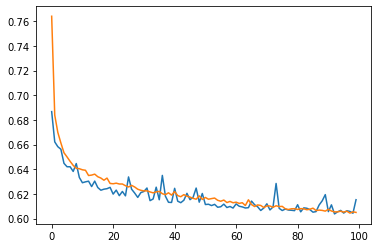

In [39]:
plt.plot(VAL_LOSS, label='Val Loss')
plt.plot(TRAIN_LOSS,label='Train Loss')

plt.show()

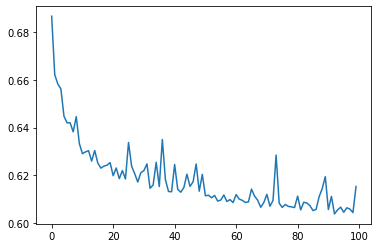

In [40]:
plt.plot(VAL_LOSS, label='Val Loss')

In [41]:
def get_predicted_keywords(edges,preds,id2img,id2word):
    
    n = edges.shape[1]
    pred_keywords_dict = {}
    
    for i in range(n):
        edge = edges[:,i]
        if(preds[i] == 1):
            if id2img[edge[0]] in pred_keywords_dict:
                pred_keywords_dict[id2img[edge[0]]].append(id2word[edge[1]])
            else:
                pred_keywords_dict[id2img[edge[0]]] = [id2word[edge[1]]]
                
    return pred_keywords_dict


def save_pred_keywords(df,img_ids,pred_keywords_dict):
    predicted_keywords = []
    for img_id in img_ids:
        if img_id in pred_keywords_dict:
            s = (';').join(pred_keywords_dict[img_id])
        else:
            s = ''
        predicted_keywords.append(s)


    df['Predicted_Keywords'] = predicted_keywords

    return df

    
def convert_zero_one(preds,threshold):
    pos_idx = preds >= threshold
    neg_idx = preds < threshold
    preds[pos_idx] = 1
    preds[neg_idx] = 0
    return preds

In [42]:
# train_edge_index = train_data['image', 'has', 'word'].edge_label_index.numpy()

In [43]:
# train_preds_zero_one = convert_zero_one(train_preds,threshold)
# val_preds_zero_one = convert_zero_one(val_preds,threshold)
# test_preds_zero_one = convert_zero_one(test_preds,threshold)

In [44]:
# pred_keywords_dict_train = get_predicted_keywords(train_edge_index,train_preds_zero_one,id2img,id2word)
# pred_keywords_dict_val = get_predicted_keywords(val_edge_index,val_preds_zero_one,id2img,id2word)
# pred_keywords_dict_test = get_predicted_keywords(test_edge_index,test_preds_zero_one,id2img,id2word)

In [45]:
# train_df_preds = save_pred_keywords(train_df,train_img_ids,pred_keywords_dict_train)
# val_df_preds = save_pred_keywords(val_df,val_img_ids,pred_keywords_dict_val)
# test_df_preds = save_pred_keywords(test_df,test_img_ids,pred_keywords_dict_test)


# train_df_preds.to_csv(word_dir+'openi_train_reports_with_preds.csv',index=False)
# val_df_preds.to_csv(word_dir+'openi_val_reports_with_preds.csv',index=False)
# test_df_preds.to_csv(word_dir+'openi_test_reports_with_preds.csv',index=False)